Users are free to copy and distribute only with citation.
https://github.com/ShravanAnandk7/Keras-Image-Embeddings-using-Contrastive-Loss

Last updated 09 Jan 2022

Import libraries

In [17]:
import os
import numpy as np
import pandas as pd
from functools import partial
from cv2 import cv2
from matplotlib import pyplot as plt
import json
import tensorflow as tf
import tensorflow.keras.utils as KU
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM
import tensorflow.keras.losses as KLo
import tensorflow.keras.optimizers as KO
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D

Setup base directory and parameters of the trained model
Train your model from https://github.com/ShravanAnandk7/Image-2-Embedding
and copy the .hf weights file in models folder

In [18]:
BASE_DIR    = os.getcwd()
MODEL_DIR       =  os.path.join(BASE_DIR,"models") # Directory with model weights
DATASET_DIR     =  os.path.join(BASE_DIR,"datasets") # Directory of images
INPUT_SHAPE     =  299
EMBEDDING_SIZE  =  32

Base model architecture, load model weights

In [19]:
def pre_process(image):
    image = cv2.resize(image,(INPUT_SHAPE, INPUT_SHAPE))
    image = image/127.5 -1
    return image
def euclidean_distance(x,y):
    """
    Euclidean distance metric
    """
    return np.sum(np.square(x-y), axis=-1)
def base_network():
    """
    Base CNN model trained for embedding extraction
    """
    return( 
            KM.Sequential(
                [   
                    KL.Input(shape=(INPUT_SHAPE,INPUT_SHAPE,3)),
                    KL.Conv2D(8,(3,3)),
                    KL.ReLU(),
                    KL.MaxPool2D(pool_size=(1,2)),
                    # KL.BatchNormalization(),
                    KL.Conv2D(16,(3,3)),
                    KL.ReLU(),
                    KL.MaxPool2D(pool_size=(2,1)),
                    KL.BatchNormalization(),
                    KL.Conv2D(32,(3,3)),
                    KL.ReLU(),
                    KL.MaxPool2D(pool_size=(1,1)),
                    KL.GlobalAveragePooling2D(),
                    # Don't Change the below layers
                    KL.Dense(EMBEDDING_SIZE,activation = 'relu'),
                    KL.Lambda(lambda x: K.l2_normalize(x,axis=-1))
                ]))
model = base_network()
model.load_weights(os.path.join(MODEL_DIR, "few-shot.h5"))

Generate embeddings of the few-shot images in the dataset/few-shot-dataset/ and save in few-shot-embedding.json file
the folder name must be the name of the object.


In [31]:
embedding_dict={}
path = os.path.join(DATASET_DIR,"few-shot-dataset")
for object in os.listdir(os.path.join(DATASET_DIR,"few-shot-dataset")):
    embedding_array = []
    for image in os.listdir(os.path.join(DATASET_DIR,"few-shot-dataset",object)):
        input = pre_process(cv2.imread(os.path.join(DATASET_DIR,"few-shot-dataset",object,image)))
        output_embeddings = model.predict(np.expand_dims(input,axis=0))
        embedding_array.append(output_embeddings[0])
    
    embedding_array = np.array(embedding_array)
    embedding_array = np.mean(embedding_array,axis=0)
    embedding_dict[object] = embedding_array.tolist()
print("Total objects/categories :",embedding_dict.keys())
with open("few-shot-emedding.json",'w') as json_file:
    json.dump(embedding_dict,json_file)

Total objects/categories : dict_keys(['airplane', 'automobile', 'bird', 'cat', 'deer', 'frog', 'horse', 'ship', 'truck'])


Predicting image.
1. Load the image 
2. Extract embeddings from the image
3. Load embeddings from the json file 
4. Calculate euclidean distance and sort in ascending order
5. Get the top 5 predictions

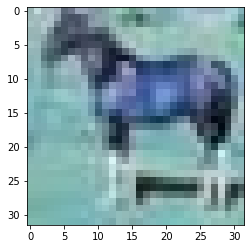

Top Predictions with (Object, Score)
 [('horse', 0.08726120126805148), ('ship', 0.09349780281149891), ('bird', 0.10591725852460712), ('automobile', 0.11266950132049558), ('truck', 0.13530947787158348)]


In [29]:
input_image = cv2.imread(os.path.join(BASE_DIR,"predict_image.jpg"))
plt.imshow(input_image)
plt.show()
model_input = pre_process(input_image)
output_embeddings = model.predict(np.expand_dims(model_input,axis=0))[0]
with open("few-shot-emedding.json",'r') as json_file:
    embedding_dict = json.load(json_file)
prediction_dict ={}
for object, embedding in embedding_dict.items():
    prediction_dict[object] = euclidean_distance( np.array(embedding) ,output_embeddings)
top_predictions = sorted(prediction_dict.items(),key = lambda x: x[1])[:5]
print("Top Predictions with (Object, Score)\n", top_predictions)

Generate embeddings of the one-shot images in the dataset/one-shot-dataset/ and save in one-shot-embedding.json file
the image file name must be the name of the object.

In [22]:
embedding_dict={}
path = os.path.join(DATASET_DIR,"one-shot-dataset")
for image in os.listdir(os.path.join(DATASET_DIR,"one-shot-dataset")):
    input = pre_process(cv2.imread(os.path.join(DATASET_DIR,"one-shot-dataset",image)))
    output_embeddings = model.predict(np.expand_dims(input,axis=0))
    embedding_dict[image[:-4]] = output_embeddings[0].tolist()
with open("one-shot-emedding.json",'w') as json_file:
    json.dump(embedding_dict,json_file)


Predicting image

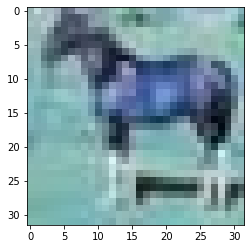

Top Predictions 
 [('horse', 0.0), ('bird', 0.08592463274802888), ('truck', 0.14489677916768023), ('cat', 0.14721649222829197), ('automobile', 0.15602874232272046)]


In [26]:
input_image = cv2.imread(os.path.join(BASE_DIR,"predict_image.jpg"))
plt.imshow(input_image)
plt.show()
model_input = pre_process(input_image)
output_embeddings = model.predict(np.expand_dims(model_input,axis=0))[0]
with open("one-shot-emedding.json",'r') as json_file:
    embedding_dict = json.load(json_file)
prediction_dict ={}
for object, embedding in embedding_dict.items():
    prediction_dict[object] = euclidean_distance( np.array(embedding) ,output_embeddings)
top_predictions = sorted(prediction_dict.items(),key = lambda x: x[1])[:5]
print("Top Predictions \n", top_predictions)